In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [3]:
from keras.models import Sequential
from keras.layers import Dense

In [4]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm 

In [5]:
total_entries = pd.read_csv('data/cleaned/NF-UQ-NIDS-CLEANED.csv', nrows=1).shape[0]

# Number of entries you want in the new dataset
target_entries = 1000

# Calculate the skiprows parameter to achieve even spread
skiprows = [i for i in range(1, total_entries) if i % (total_entries // target_entries) != 0]

# Read a subset of the original dataset
new_dataset = pd.read_csv('data/cleaned/NF-UQ-NIDS-CLEANED.csv', skiprows=skiprows)

In [10]:
label_encoder = LabelEncoder()

# Convert object type columns to integers
text_columns = new_dataset.select_dtypes(include=['object']).columns
for column in text_columns:
    new_dataset[column] = label_encoder.fit_transform(new_dataset[column].astype(str))

# Convert boolean type columns to integers
bool_columns = new_dataset.select_dtypes(include=['bool']).columns
for column in bool_columns:
    new_dataset[column] = new_dataset[column].astype(int)

features = list(new_dataset.columns)
label = ['Attack']

X = new_dataset[features]
Y = new_dataset[label]

In [11]:
print (new_dataset.tail())


          Unnamed: 0  L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  \
11994884    11994886           80           80        17       0.0   2385573   
11994885    11994887           80           80         6       7.0    240264   
11994886    11994888           80           80         6       7.0   2330065   
11994887    11994889            0            0         6       0.0   1054423   
11994888    11994890          365          565        17       0.0     62422   

          OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_FLAGS  ...  dIP9  dIP8  dIP7  \
11994884          0     2523         0          0  ...     0     0     0   
11994885          0      852         0          0  ...     0     0     0   
11994886          0     2523         0          0  ...     0     0     0   
11994887          0     1513         0          0  ...     1     0     0   
11994888          0     1357         0          0  ...     0     0     1   

          dIP6  dIP5  dIP4  dIP3  dIP2  dIP1  dIP0  
11994884 

In [12]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Training a Random Forest classifier with tqdm progress bar
clf_true = RandomForestClassifier(n_estimators=100)

# Adding tqdm to track progress
with tqdm(total=len(X_true_train), desc="Training Progress") as pbar:
    clf_true.fit(X_true_train, y_true_train)
    pbar.update(len(X_true_train))

# Making predictions on the test set
y_true_pred = clf_true.predict(X_true_test)

# Evaluating the model
print("Base Accuracy:", metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:", metrics.classification_report(y_true_test, y_true_pred))

Training Progress:   0%|          | 0/8396422 [00:00<?, ?it/s]c:\Users\shrey\anaconda3\envs\torch4\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Training Progress: 100%|██████████| 8396422/8396422 [26:57<00:00, 5190.41it/s]


Base Accuracy: 0.999939418646885
Base classification report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98       587
           1       1.00      1.00      1.00      5707
           2       1.00      1.00      1.00   2761745
           3       1.00      1.00      1.00      4737
           4       1.00      1.00      1.00     87505
           5       1.00      1.00      1.00    229352
           6       1.00      1.00      1.00    104676
           7       0.99      1.00      0.99      7447
           8       1.00      1.00      1.00      5921
           9       0.99      0.99      0.99      1710
          10       1.00      1.00      1.00     18717
          11       1.00      1.00      1.00    144513
          12       0.98      1.00      0.99       397
          13       1.00      0.99      1.00       542
          14       1.00      0.70      0.82        47
          15       1.00      1.00      1.00    140763
          16       0

In [13]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [14]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [26]:
def generate_real_samples(n):
    X = new_dataset.sample(n)
    y = np.ones((n, 1))
    return X, y

In [16]:
def define_generator(latent_dim, n_outputs=78):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [17]:
generator1 = define_generator(10, 78)
generator1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 78)                2418      
                                                                 
Total params: 3063 (11.96 KB)
Trainable params: 3063 (11.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
def define_discriminator(n_inputs=78):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [19]:
discriminator1 = define_discriminator(78)
discriminator1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                1975      
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3326 (12.99 KB)
Trainable params: 3326 (12.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [30]:
def plot_history(d_hist, g_hist):
    # Clip values to be between 0 and 1
    d_hist = np.clip(d_hist, 0, 10)
    g_hist = np.clip(g_hist, 0, 10)

    # Plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    
    # Set y-axis limit to 1
    plt.ylim(0, 10)
    
    plt.show()
    plt.close()

In [35]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
    
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
        print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
        d_history.append(d_loss)
        g_history.append(g_loss_fake)
    plot_history(d_history, g_history)
        
    g_model.save('trained_generated_model.h5')

2/2 [==============================] - 0s 2ms/step
>1, d1=0.000, d2=0.784 d=0.392 g=0.644
2/2 [==============================] - 0s 3ms/step
>2, d1=0.000, d2=0.740 d=0.370 g=0.656
2/2 [==============================] - 0s 3ms/step
>3, d1=0.000, d2=0.765 d=0.383 g=0.667
2/2 [==============================] - 0s 2ms/step
>4, d1=85.983, d2=0.766 d=43.374 g=0.664
2/2 [==============================] - 0s 2ms/step
>5, d1=0.000, d2=0.751 d=0.375 g=0.648
2/2 [==============================] - 0s 2ms/step
>6, d1=41.176, d2=0.751 d=20.963 g=0.657
2/2 [==============================] - 0s 2ms/step
>7, d1=2136.313, d2=0.735 d=1068.524 g=0.639
2/2 [==============================] - 0s 1ms/step
>8, d1=0.000, d2=0.772 d=0.386 g=0.646
2/2 [==============================] - 0s 2ms/step
>9, d1=0.000, d2=0.776 d=0.388 g=0.645
2/2 [==============================] - 0s 1ms/step
>10, d1=0.000, d2=0.770 d=0.385 g=0.637
2/2 [==============================] - 0s 3ms/step
>11, d1=0.000, d2=0.763 d=0.381 g=0.63

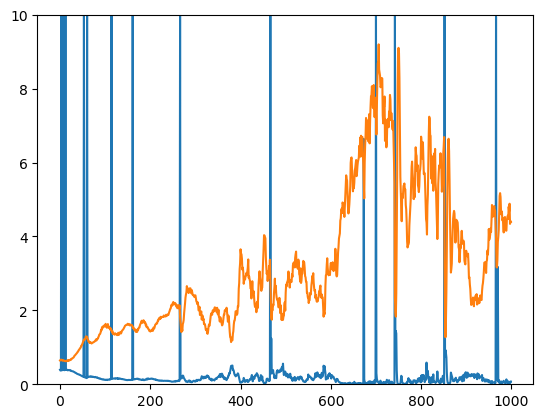

c:\Users\shrey\anaconda3\envs\torch4\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)


In [38]:
from keras.models import load_model
model = load_model('trained_generated_model.h5')

In [39]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=new_dataset.columns.tolist())
data_fake.head()

24/24 [==============================] - 0s 870us/step


,Unnamed: 0,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,...,dIP9,dIP8,dIP7,dIP6,dIP5,dIP4,dIP3,dIP2,dIP1,dIP0
0,62.470268,37.519890,-3.187165,-1.866207,-0.375650,41.287373,25.558901,0.248783,11.130185,-1.443575,...,-2.909859,5.290975,0.939451,2.770931,-0.283336,-0.103274,1.414967,4.254495,3.828449,3.565393
1,191.708420,116.547913,-14.438709,-6.111710,-0.657118,126.252029,76.508186,5.087196,30.601408,-6.577285,...,-9.579031,14.550053,4.403975,7.929540,-1.331275,3.080043,3.265130,9.973379,8.716519,11.856589
2,201.718948,125.698357,-15.895570,-8.242013,-1.113987,132.446884,80.675827,8.008824,31.117819,-5.490180,...,-10.521648,18.308331,1.282237,7.158123,-0.762855,2.462794,3.983288,10.082767,7.574588,8.883588
3,117.691803,70.846497,-6.831321,-3.096210,-0.781678,80.519279,47.273361,2.039948,22.255579,-4.668008,...,-5.231583,10.246824,2.462288,4.880078,-1.351796,0.106907,4.103042,7.067055,7.379181,6.534048
4,210.850937,132.248810,-16.559408,-9.468728,-2.006718,136.589417,84.431801,7.423054,31.121399,-6.311764,...,-10.871540,18.565334,2.233274,9.080914,-1.317468,4.207884,3.702857,8.679863,8.896867,9.767197


In [40]:
outcome_mean = data_fake.Attack.mean()
data_fake['Attack'] = data_fake['Attack'] > outcome_mean
data_fake["Attack"] = data_fake["Attack"].astype(int)

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label = ['Outcome']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]